In [35]:
using Oceananigans
using Oceananigans.Units
using Oceananigans.OutputReaders: FieldTimeSeries

In [36]:
Lx = 1000kilometers # east-west extent [m]
Ly = 1000kilometers # north-south extent [m]
Lz = 1kilometers    # depth [m]

grid = RectilinearGrid(size = (48, 8),
                       y = (-Ly/2, Ly/2),
                       z = (-Lz, 0),
                       topology = (Flat, Bounded, Bounded))

1×48×8 RectilinearGrid{Float64, Flat, Bounded, Bounded} on CPU with 0×3×3 halo
├── Flat x                             
├── Bounded  y ∈ [-500000.0, 500000.0] regularly spaced with Δy=20833.3
└── Bounded  z ∈ [-1000.0, 0.0]        regularly spaced with Δz=125.0

In [37]:
model = HydrostaticFreeSurfaceModel(; grid,
                                    coriolis = BetaPlane(latitude = -45),
                                    buoyancy = BuoyancyTracer(),
                                    tracers = :b,
                                    momentum_advection = WENO(),
                                    tracer_advection = WENO())

HydrostaticFreeSurfaceModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── grid: 1×48×8 RectilinearGrid{Float64, Flat, Bounded, Bounded} on CPU with 0×3×3 halo
├── timestepper: QuasiAdamsBashforth2TimeStepper
├── tracers: b
├── closure: Nothing
├── buoyancy: BuoyancyTracer with ĝ = NegativeZDirection()
├── free surface: ImplicitFreeSurface with gravitational acceleration 9.80665 m s⁻²
│   └── solver: FFTImplicitFreeSurfaceSolver
├── advection scheme: 
│   ├── momentum: WENO(order=5)
│   └── b: WENO(order=5)
└── coriolis: BetaPlane{Float64}

In [38]:
"""
    ramp(y, Δy)

Linear ramp from 0 to 1 between -Δy/2 and +Δy/2.

For example:
```
            y < -Δy/2 => ramp = 0
    -Δy/2 < y < -Δy/2 => ramp = y / Δy
            y >  Δy/2 => ramp = 1
```
"""
ramp(y, Δy) = min(max(0, y/Δy + 1/2), 1)

N² = 1e-5 # [s⁻²] buoyancy frequency / stratification
M² = 1e-7 # [s⁻²] horizontal buoyancy gradient

Δy = 100kilometers # width of the region of the front
Δb = Δy * M²       # buoyancy jump associated with the front
ϵb = 1e-2 * Δb     # noise amplitude

bᵢ(y, z) = N² * z + Δb * ramp(y, Δy) + ϵb * randn()

set!(model, b=bᵢ)

In [39]:
simulation = Simulation(model, Δt=20minutes, stop_time=30days)

Simulation of HydrostaticFreeSurfaceModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 20 minutes
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: 30 days
├── Stop iteration: Inf
├── Wall time limit: Inf
├── Minimum relative step: 0.0
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   └── nan_checker => Callback of NaNChecker for u on IterationInterval(100)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [40]:
conjure_time_step_wizard!(simulation, IterationInterval(20), cfl=0.2, max_Δt=20minutes)

In [41]:
using Printf

wall_clock = Ref(time_ns())

function print_progress(sim)
    u, v, w = model.velocities
    progress = 100 * (time(sim) / sim.stop_time)
    elapsed = (time_ns() - wall_clock[]) / 1e9

    @printf("[%05.2f%%] i: %d, t: %s, wall time: %s, max(u): (%6.3e, %6.3e, %6.3e) m/s, next Δt: %s\n",
            progress, iteration(sim), prettytime(sim), prettytime(elapsed),
            maximum(abs, u), maximum(abs, v), maximum(abs, w), prettytime(sim.Δt))

    wall_clock[] = time_ns()

    return nothing
end

add_callback!(simulation, print_progress, IterationInterval(100))

Diagnostics/Output

In [42]:
# Output setup
filename = "baroclinic_2D_yz.v2"
u, v, w = model.velocities
ζ = ∂z(v) - ∂y(w)  # Vorticity in y-z plane
b = model.tracers.b

simulation.output_writers[:fields] = JLD2Writer(
    model, (; b, ζ, v, w),
    filename=filename * ".jld2",
    schedule=TimeInterval(0.5day),
    overwrite_existing=true
)

JLD2Writer scheduled on TimeInterval(12 hours):
├── filepath: baroclinic_2D_yz.v2.jld2
├── 4 outputs: (b, ζ, v, w)
├── array type: Array{Float32}
├── including: [:grid, :coriolis, :buoyancy, :closure]
├── file_splitting: NoFileSplitting
└── file size: 36.7 KiB

In [43]:
@info "Running the simulation..."

run!(simulation)

@info "Simulation completed in " * prettytime(simulation.run_wall_time)

┌ Info: Running the simulation...
└ @ Main c:\Users\Tom Cummings\OneDrive - University of Edinburgh\Documents\Oceananigians\Examples\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X12sZmlsZQ==.jl:1
┌ Info: Initializing simulation...
└ @ Oceananigans.Simulations C:\Users\Tom Cummings\.julia\packages\Oceananigans\TXJRi\src\Simulations\run.jl:205


[00.00%] i: 0, t: 0 seconds, wall time: 7.528 seconds, max(u): (0.000e+00, 0.000e+00, 0.000e+00) m/s, next Δt: 20 minutes


┌ Info:     ... simulation initialization complete (2.558 seconds)
└ @ Oceananigans.Simulations C:\Users\Tom Cummings\.julia\packages\Oceananigans\TXJRi\src\Simulations\run.jl:248
┌ Info: Executing initial time step...
└ @ Oceananigans.Simulations C:\Users\Tom Cummings\.julia\packages\Oceananigans\TXJRi\src\Simulations\run.jl:139
┌ Info:     ... initial time step complete (2.605 seconds).
└ @ Oceananigans.Simulations C:\Users\Tom Cummings\.julia\packages\Oceananigans\TXJRi\src\Simulations\run.jl:168


[04.63%] i: 100, t: 1.389 days, wall time: 5.167 seconds, max(u): (1.002e-01, 1.293e-01, 2.580e-03) m/s, next Δt: 20 minutes
[09.26%] i: 200, t: 2.778 days, wall time: 257.662 ms, max(u): (1.884e-01, 1.938e-01, 2.978e-03) m/s, next Δt: 20 minutes
[13.89%] i: 300, t: 4.167 days, wall time: 309.844 ms, max(u): (2.613e-01, 2.218e-01, 2.692e-03) m/s, next Δt: 20 minutes
[18.52%] i: 400, t: 5.556 days, wall time: 270.231 ms, max(u): (3.114e-01, 2.343e-01, 2.189e-03) m/s, next Δt: 20 minutes
[23.15%] i: 500, t: 6.944 days, wall time: 310.669 ms, max(u): (3.522e-01, 2.139e-01, 2.694e-03) m/s, next Δt: 20 minutes
[27.78%] i: 600, t: 8.333 days, wall time: 279.261 ms, max(u): (3.863e-01, 1.856e-01, 2.331e-03) m/s, next Δt: 20 minutes
[32.41%] i: 700, t: 9.722 days, wall time: 225.426 ms, max(u): (4.339e-01, 1.707e-01, 3.016e-03) m/s, next Δt: 20 minutes
[37.04%] i: 800, t: 11.111 days, wall time: 244.745 ms, max(u): (4.811e-01, 1.594e-01, 4.040e-03) m/s, next Δt: 20 minutes
[41.67%] i: 900, t: 

┌ Info: Simulation is stopping after running for 11.040 seconds.
└ @ Oceananigans.Simulations C:\Users\Tom Cummings\.julia\packages\Oceananigans\TXJRi\src\Simulations\simulation.jl:223
┌ Info: Simulation time 30 days equals or exceeds stop time 30 days.
└ @ Oceananigans.Simulations C:\Users\Tom Cummings\.julia\packages\Oceananigans\TXJRi\src\Simulations\simulation.jl:224
┌ Info: Simulation completed in 11.052 seconds
└ @ Main c:\Users\Tom Cummings\OneDrive - University of Edinburgh\Documents\Oceananigians\Examples\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X12sZmlsZQ==.jl:5


Vizualisation

In [44]:
# Visualization
b_ts = FieldTimeSeries(filename * ".jld2", "b")
ζ_ts = FieldTimeSeries(filename * ".jld2", "ζ")

v_ts = FieldTimeSeries(filename * ".jld2", "v")
w_ts = FieldTimeSeries(filename * ".jld2", "w")

times = b_ts.times

0.0:43200.0:2.592e6

In [45]:
# Coordinates
y = ynodes(grid, Center())# ./ 1e3  # km
z = znodes(grid, Center())# ./ 1e3  # km

8-element view(OffsetArray(::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, -2:11), 1:8) with eltype Float64:
 -937.5
 -812.5
 -687.5
 -562.5
 -437.5
 -312.5
 -187.5
  -62.5

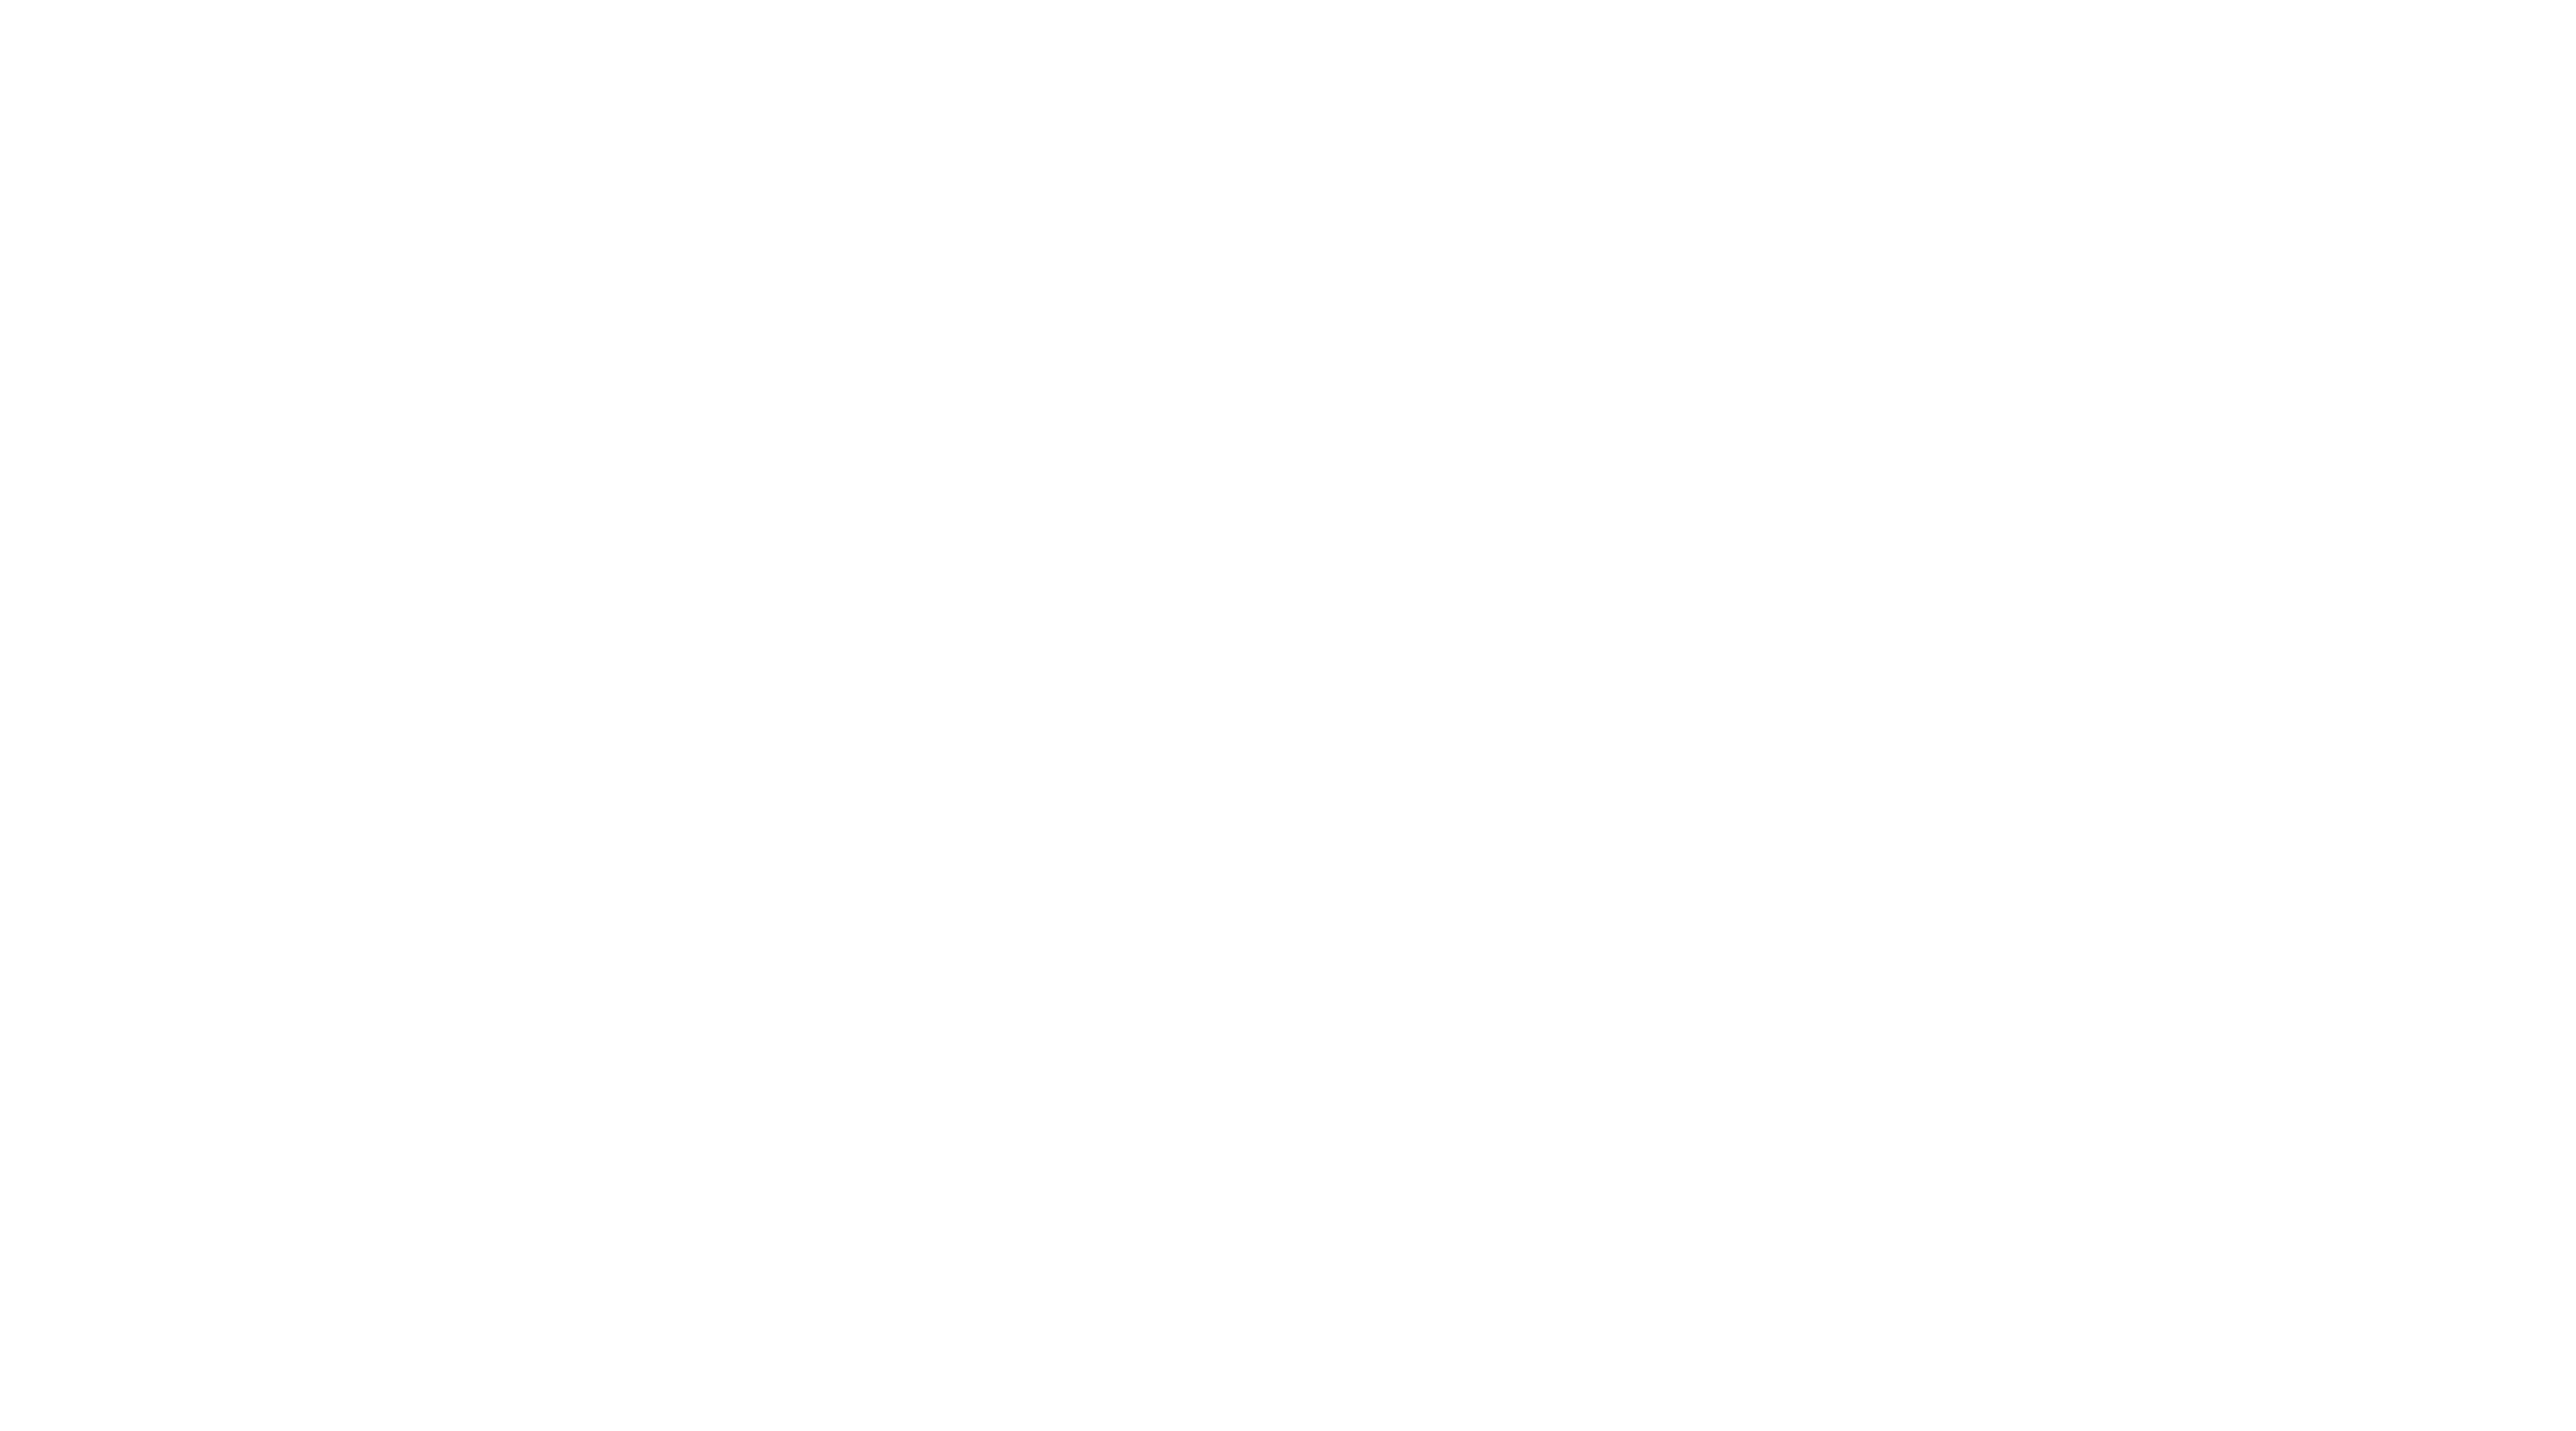

In [46]:

using CairoMakie
fig = Figure(size=(1800, 1000))

In [47]:
# Animation setup
n = Observable(1)
b_slice = @lift interior(b_ts[$n], 1, :, :)
ζ_slice = @lift interior(ζ_ts[$n], 1, :, :)

v_slice = @lift interior(v_ts[$n], 1, :, :)
w_slice = @lift interior(w_ts[$n], 1, :, :)

title_text = @lift "Day $(round(times[$n]/day, digits=1))"

Observable("Day 0.0")


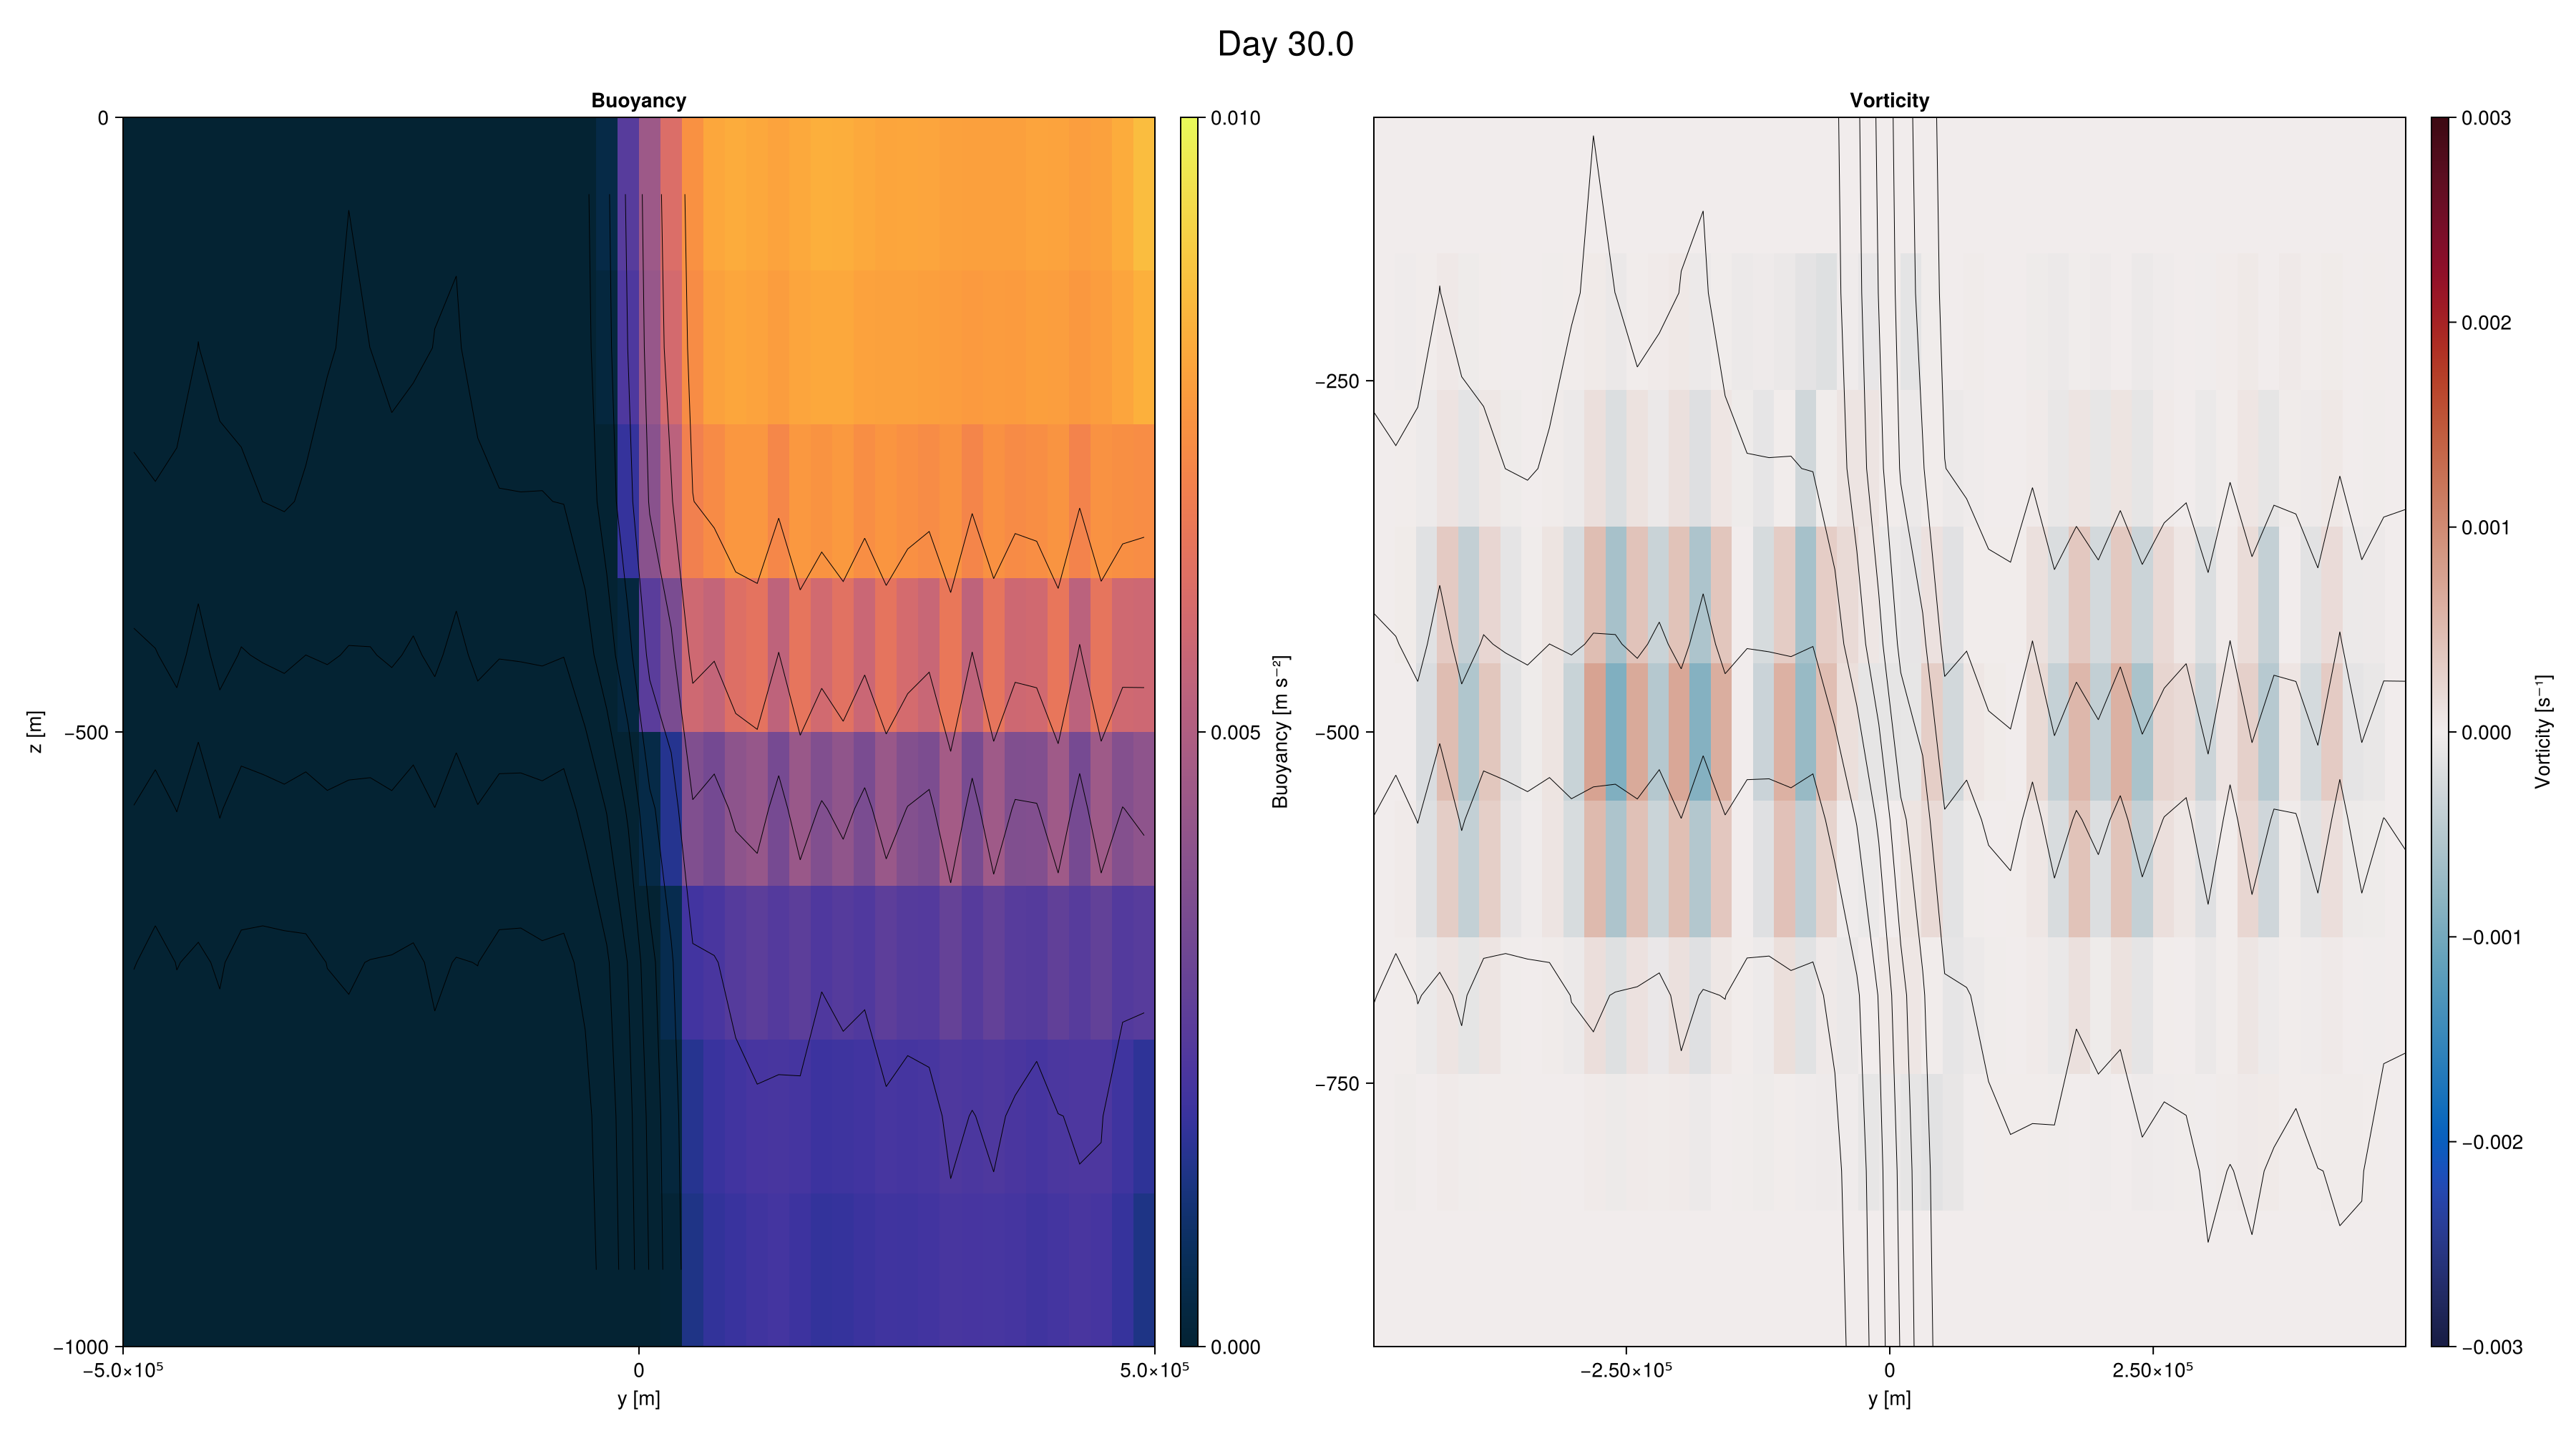

In [ ]:
# Animations of Buoyancy and Vorticity commented 

#=

empty!(fig)

# Buoyancy plot
ax_b = Axis(fig[1, 1], title="Buoyancy", xlabel="y [m]", ylabel="z [m]")
hm_b = heatmap!(ax_b, y, z, b_slice, colorrange=(0, Δb), colormap=:thermal)
contour!(ax_b, y, z, b_slice, levels=10, color=:black, linewidth=0.5)
Colorbar(fig[1, 2], hm_b, label="Buoyancy [m s⁻²]")

# Vorticity plot
ax_ζ = Axis(fig[1, 3], title="Vorticity", xlabel="y [m]")
hm_ζ = heatmap!(ax_ζ, y, z, ζ_slice, colorrange=(-3e-3, 3e-3), colormap=:balance)
contour!(ax_ζ, y, z, b_slice, levels=10, color=:black, linewidth=0.5)  # Overlay buoyancy contours
Colorbar(fig[1, 4], hm_ζ, label="Vorticity [s⁻¹]")

Label(fig[0, :], title_text, fontsize=24)

# Create animation
frames = 1:length(times)
record(fig, filename * "_animation.mp4", frames, framerate=8) do i
    n[] = i
end

fig  # Display final frame

=#

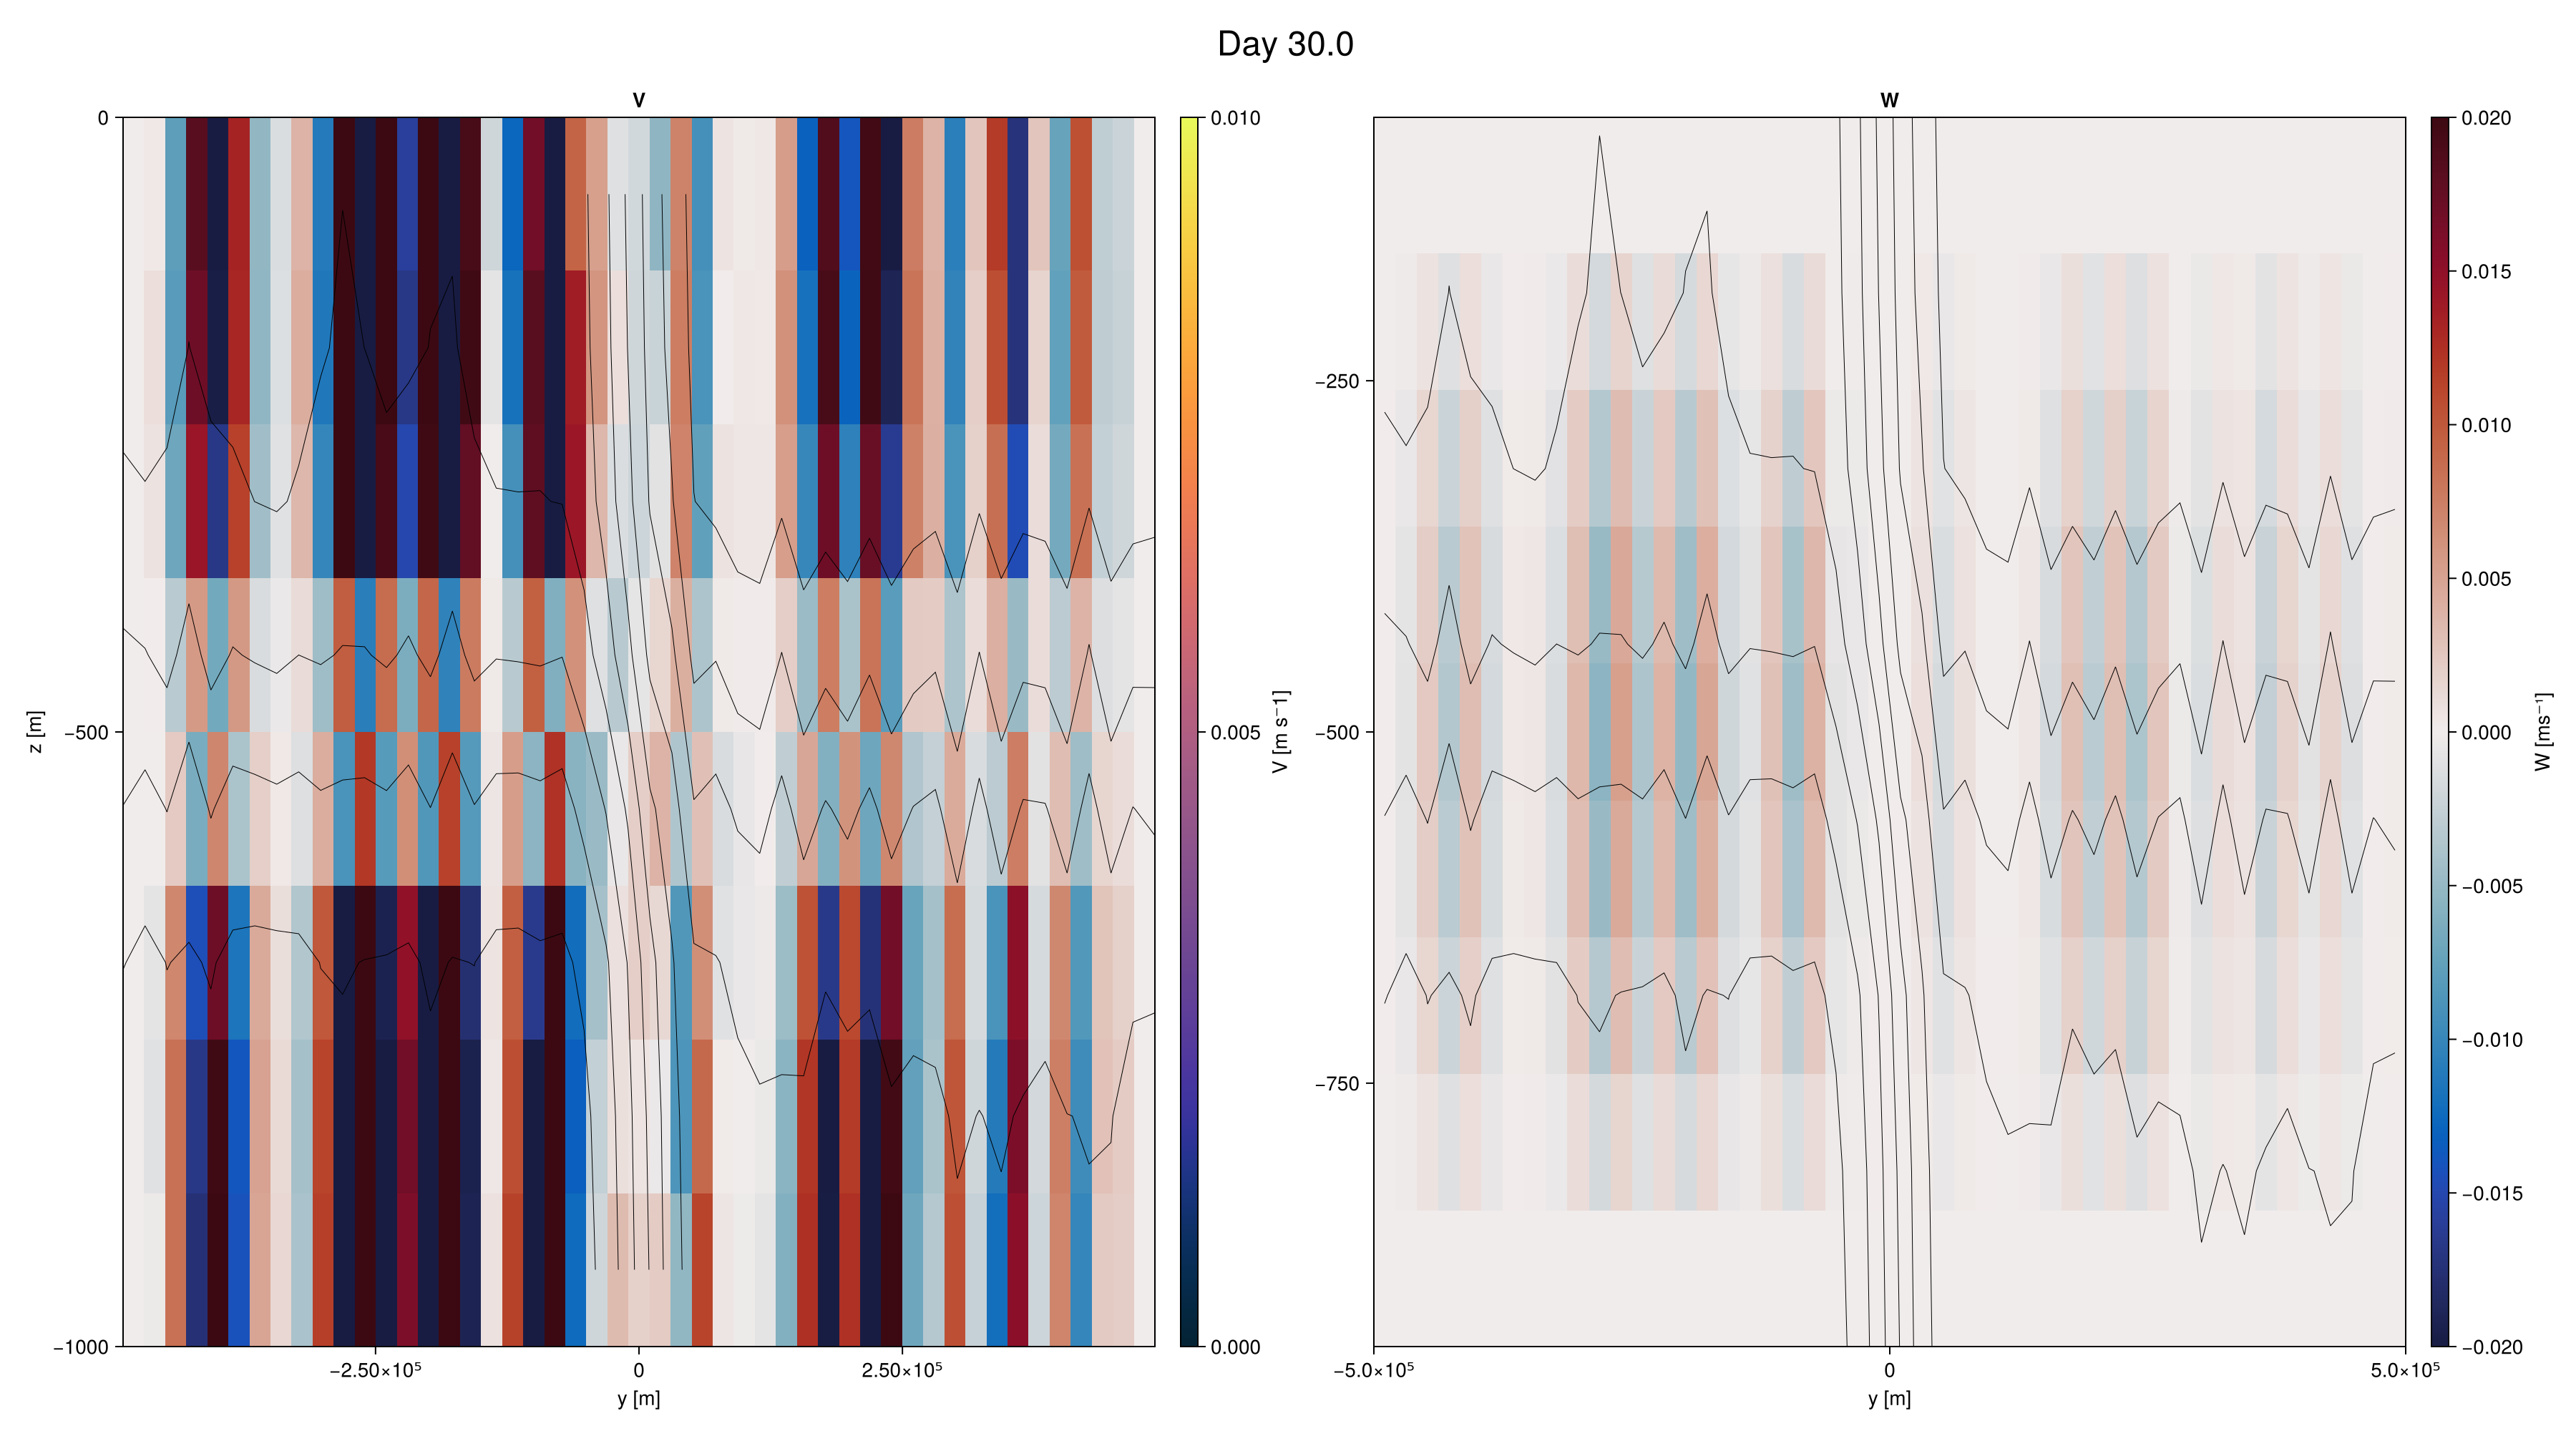

In [ ]:
#animations of of V and W commented out

#=

# y velocity (v)

empty!(fig)

ax_v = Axis(fig[1, 1], title="V", xlabel="y [m]", ylabel="z [m]")
hm = heatmap!(ax_v, y, z, v_slice; colorrange=(-1e-1, 1e-1), colormap=:balance)
Colorbar(fig[1, 2], hm_b, label="V [m s⁻1]")
contour!(ax_v, y, z, b_slice, levels=10, color=:black, linewidth=0.5)

# z velocity (w)
ax_w = Axis(fig[1, 3], title="W", xlabel="y [m]")
hm_w = heatmap!(ax_w, y, z, w_slice, colorrange=(-2e-2, 2e-2), colormap=:balance)
contour!(ax_w, y, z, b_slice, levels=10, color=:black, linewidth=0.5)  # Overlay buoyancy contours
Colorbar(fig[1, 4], hm_w, label="W [ms⁻¹]")

Label(fig[0, :], title_text, fontsize=24)

# Create animation
frames = 1:length(times)
record(fig, filename * "_animation_velocities.mp4", frames, framerate=8) do i
    n[] = i
end

fig  # Display final frame 

=#

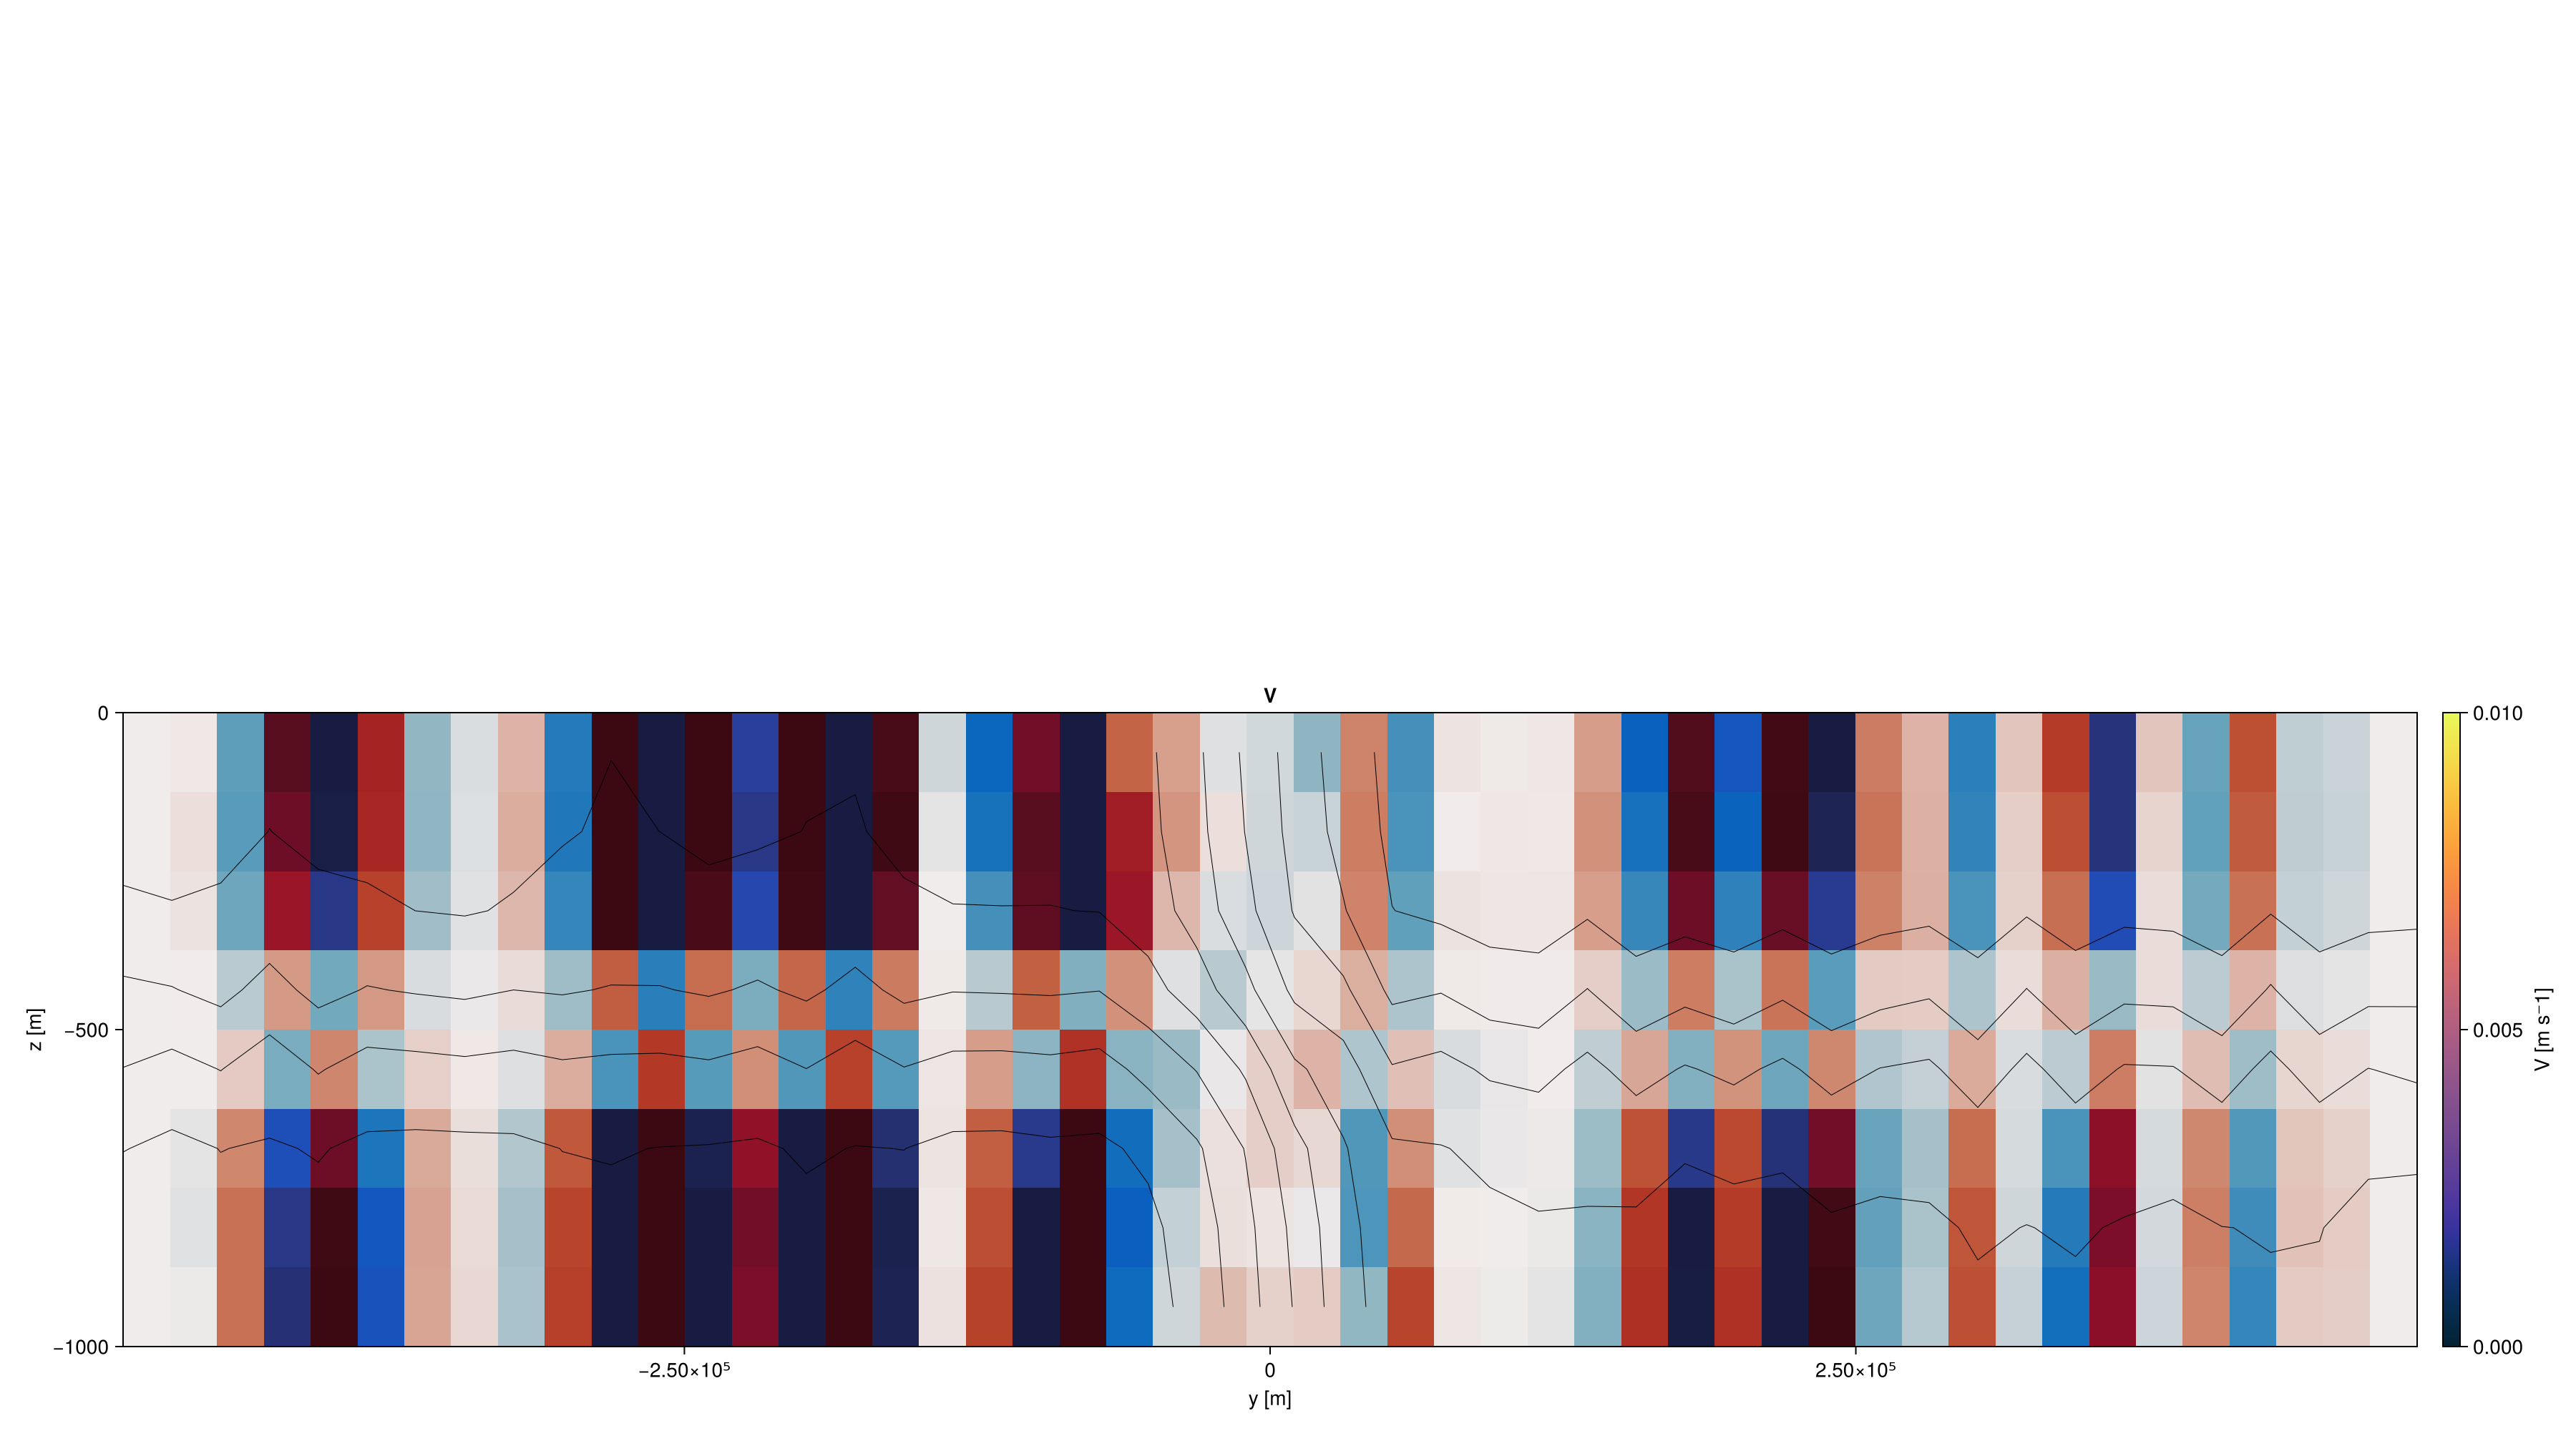

In [50]:
#simualtion of V only (bottom right)

empty!(fig)

ax_v = Axis(fig[1, 1], title="V", xlabel="y [m]", ylabel="z [m]")
hm = heatmap!(ax_v, y, z, v_slice; colorrange=(-1e-1, 1e-1), colormap=:balance)
Colorbar(fig[1, 2], hm_b, label="V [m s⁻1]")
contour!(ax_v, y, z, b_slice, levels=10, color=:black, linewidth=0.5)


# Create animation
frames = 1:length(times)
record(fig, filename * "_animation_velocities.mp4", frames, framerate=8) do i
    n[] = i
end

fig  # Display final frame